# Sentiment Analysis -- iMDB Dataset

### beginning with some data preprocessing 

read_imdb_data reads the data contained in a file including training and test sets divided in positive and negative

In [1]:
import os
import glob
import pickle
import preprocess_library as kit 


# Read imdb data and write them into pickle files
if not (os.path.isfile('data.pickle') and os.path.isfile('labels.pickle')):
    data, labels = kit.read_imdb_data()
    with open("data.pickle", "wb") as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open("labels.pickle", "wb") as handle:
        pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

        
# Open the pickle files
if os.path.getsize("data.pickle") > 0:
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
else:
    print ("You're trying to load an empty file")

    
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gpagk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


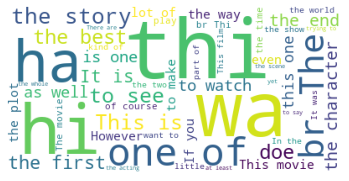

In [2]:
# Create a wordcloud from positive reviews    
kit.wordcloud_by_sentiment(data=data,sentiment='pos')

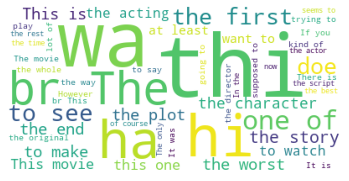

In [3]:
# Create a wordcloud from negative reviews
kit.wordcloud_by_sentiment(data,'neg')

prepare_imdb_data combines the positive and negative documents to get one unified training set and one unified test set.

In [4]:
data_train, data_test, labels_train, labels_test = kit.prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


review_to_words removes HTML tags, non-letter characters, normalizes uppercase letters by converting them to lowercase, tokenizes, removes stop words, and stem the remaining words in each document.

In [5]:
kit.review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', 'test', 'would', 'make', 'great', 'movi', 'review']

preprocess_data applies review_to_words to test and training datasets. Also writes in cache files to have this information ready in future runs.

In [6]:
# Preprocess data
words_train, words_test, labels_train, labels_test = kit.preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Read preprocessed data from cache file: preprocessed_data.pkl

--- Raw review ---
If this movie were any worse, it would have been directed by Uwe Boll. This nonsensical mess makes Ed Wood look like Hitchcock. It has been a while since I have seen this steaming pile , but I do remember that I wanted to do grievous bodily harm to all those involved. How anyone can give this movie any more than 1 star amazes me to the graciousness of all those that viewed this tripe. I give it one star because there is not a rating lower. All copies of this movie should be burned the ground sowed with salt and reserved as a landfill for the most toxic of waste. No, one copy should be kept under ultra hi security and shown only to film makers as an example of how not to do it.

--- Preprocessed words ---
['sorri', 'aw', 'told', 'peopl', 'film', 'bad', 'act', 'almost', 'believ', 'noth', 'wrong', 'idea', 'modern', 'day', 'japanes', 'troop', 'get', 'pull', 'back', 'time', 'day', 'busido', 'warrior', 'modern'

The extract_BoW_features() function, applied to both training and test datasets, stores the results in features_train and features_test Numpy arrays, respectively. The vocabulary size, say  |𝑉|=5000 , specifies that only the top  |𝑉|  occuring words are considered and the rest is discarded. This number will also serve as the number of columns in the BoW matrices.

We will take advantage of CountVectorizer from scikit-learn, and pickle the Bag-of-Words transformation so that we can use it in future.

In [7]:
# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = kit.extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Wrote features to cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['mostli', 'mall', 'float', 'televis', 'market', 'unsur', 'ethnic', 'tripl']

--- Preprocessed words ---
['peach', 'truli', 'marvel', 'film', 'write', 'refut', 'review', 'someon', 'call', 'auscrit', 'appear', 'site', 'first', 'idea', 'either', 'monahan', 'first', 'film', 'interview', 'somehow', 'tv', 'extraordinari', 'statement', 'film', 'significantli', 'prais', 'around', 'world', 'simpli', 'one', 'best', 'australian', 'film', 'ever', 'made', 'fulli', 'deserv', 'win', 'best', 'pictur', 'peach', 'brave', 'bold', 'courag', 'departur', 'work', 'everi', 'level', 'seen', 'twice', 'monahan', 'filmmak', 'demonstr', 'great', 'skill', 'incred', 'sensit', 'auscrit', 'make', 'comment', 'anoth', 'tv', 'movi', 'etc', 'hugo', 'weav', 'good', 'simpli', 'get', 'film', 'particularli', 'want', 'get', 'frankli', 'sort', 'comment', 'one', 'expect', 'either', 'anoth', 'filmmak', 'jealou', 'bitter', 'someon', 'insid', 'indu

In [8]:
import sklearn.preprocessing as pr

# Normalize BoW features in training and test set
features_train = pr.normalize(features_train)
features_test = pr.normalize(features_test)

# Models

In [9]:
from sklearn.naive_bayes import GaussianNB

# Train a Guassian Naive Bayes classifier
clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.81904, test = 0.72424


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# The best n_estimators is 160
# Here is the range on which I performed GridSearchCV: params = {"n_estimators": range(10, 200, 10)}
# Use only 160 to avoid rerunning gridsearch on the whole range(10,200,10)
params = {"n_estimators": [160]}

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    gbc = GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0,verbose=True)
    
    # Perform hyperparameter tuning
    grid_search = GridSearchCV(gbc, params, verbose=2)
    grid_search.fit(X_train, y_train)
    clf = grid_search.best_estimator_
    print ("Best n_estimators: ", grid_search.best_params_)
    
    # Print final training & test accuracy
    print ("[{}] Accuracy: train = {}, test = {}".format(
    clf.__class__.__name__,
    clf.score(X_train, y_train),
    clf.score(X_test, labels_test)))
    # Return best classifier model
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_estimators=160 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      Iter       Train Loss   Remaining Time 
         1           1.3044            8.62m
         2           1.2501            8.53m
         3           1.2031            8.64m
         4           1.1680            8.59m
         5           1.1452            8.39m


In [ ]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
lr=LogisticRegression(n_jobs=-1,penalty='l2', max_iter=500,C=1,random_state=42,verbose=1)
#Fitting the model for Bag of words
lr_bow=lr.fit(features_train, labels_train)
print(lr_bow)
print(lr.score(features_train, labels_train))
print(lr.score(features_test, labels_test))

In [ ]:
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42,verbose=True)
#fitting the svm for bag of words
svm_bow=svm.fit(features_train, labels_train)
print(svm_bow)
print(svm.score(features_train, labels_train))
print(svm.score(features_test, labels_test))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Instantiate Random Forest Classifier
randforest = RandomForestClassifier(n_estimators=800,
                                   max_depth=4,
                                   min_samples_leaf=0.001,
                                   random_state=42,verbose=True,
                                   n_jobs=-1)
 
# Fit model to the training set
randforest.fit(features_train, labels_train)
print(randforest.score(features_train, labels_train))
print(randforest.score(features_test, labels_test))

In [ ]:
from keras.datasets import imdb
vocabulary_size = 5000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocabulary_size)
print('Loaded dataset with {} training samples, {} test samples'.format(len(X_train), len(X_test)))


In [ ]:
from keras.utils import pad_sequences

max_words = 500
X_train = pad_sequences(X_train, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)

In [ ]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import adam_v2

learning_rate = 0.001
embedding_size=32
model=Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

In [ ]:
model.compile(loss='binary_crossentropy', 
             optimizer=adam_v2.Adam(learning_rate), 
             metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)

model_file = "rnn_model.h5"  # HDF5 file

checkpointer = ModelCheckpoint(filepath=os.path.join(cache_dir, model_file), verbose=1, 
                               save_best_only=True)
# Stop training if the validation loss doesn't fall for 3 consecutive epochs
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
# Train the model, reserve some training data for validation

batch_size = 64
num_epochs = 3

X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]

hist = model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs,callbacks=[checkpointer, earlystopping])


In [ ]:
# Later we can load it using keras.models.load_model()
from keras.models import load_model
model = load_model(os.path.join(cache_dir, model_file))

In [ ]:
# Evaluate the model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy that I passed in metrics=['accuracy']